In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [29]:
data_dir = './archive'

In [30]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")  # Convertir a RGB para ResNet
        if self.transform:
            image = self.transform(image)
        return image, label

In [41]:
# Función para cargar las imágenes y sus etiquetas
def load_data(data_dir):
    file_paths = []
    labels = []
    class_mapping = {
        "decks/cracked": 0,
        "decks/non-cracked": 1,
        "pavements/cracked": 2,
        "pavements/non-cracked": 3,
        "walls/cracked": 4,
        "walls/non-cracked": 5,
    }

    for label, idx in class_mapping.items():
        folder = os.path.join(data_dir, label)
        if os.path.exists(folder):  # Verificar que la carpeta exista
            for file in os.listdir(folder):
                file_path = os.path.join(folder, file)
                if os.path.isfile(file_path):  # Verificar que es un archivo válido
                    file_paths.append(file_path)
                    labels.append(idx)

    return file_paths, labels
file_paths, labels = load_data(data_dir)

In [33]:
# Dividir datos
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=26, stratify=labels
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=26, stratify=train_labels
)

In [42]:
# Transformaciones y DataLoaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = CustomDataset(train_paths, train_labels, transform=transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [44]:
# Definición del modelo
class ConvNet(nn.Module):
    def __init__(self, dropout=0.2):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [45]:
# Configuración de hiperparámetros
params = {
    'dropout': 0.2,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'batch_size': 64,
    'epochs': 10,
    'patience': 3,
}

In [47]:
# Inicializar modelo, criterio y optimizador
def initialize_model(params):
    model = ConvNet(dropout=params['dropout'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay']
    )
    return model, criterion, optimizer

model, criterion, optimizer = initialize_model(params)

In [50]:
# Entrenamiento
best_val_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model_resnet18.pth'

for epoch in range(params['epochs']):
    # Entrenamiento
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    val_loss /= len(val_loader)
    report = classification_report(y_true, y_pred, output_dict=True)
    val_accuracy = report['accuracy']
    val_f1 = report['weighted avg']['f1-score']

    # Métricas de la época
    print(f"Epoch {epoch + 1}/{params['epochs']} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, "
          f"Val F1-Score: {val_f1:.4f}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
        print(f"Guardando el mejor modelo con pérdida de validación {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"No hay mejora en la pérdida de validación por {patience_counter} época(s).")

    if patience_counter >= params['patience']:
        print("Early stopping activado. Entrenamiento detenido.")
        break

Epoch 1/10 - Train Loss: 0.9834, Val Loss: 0.9645, Val Accuracy: 0.5483, Val F1-Score: 0.5311
Guardando el mejor modelo con pérdida de validación 0.9645
Epoch 2/10 - Train Loss: 0.9727, Val Loss: 0.9943, Val Accuracy: 0.5217, Val F1-Score: 0.5049
No hay mejora en la pérdida de validación por 1 época(s).
Epoch 3/10 - Train Loss: 0.9727, Val Loss: 0.9221, Val Accuracy: 0.5402, Val F1-Score: 0.4995
Guardando el mejor modelo con pérdida de validación 0.9221
Epoch 4/10 - Train Loss: 0.9398, Val Loss: 0.9339, Val Accuracy: 0.5247, Val F1-Score: 0.4657
No hay mejora en la pérdida de validación por 1 época(s).
Epoch 5/10 - Train Loss: 0.8970, Val Loss: 0.8618, Val Accuracy: 0.5873, Val F1-Score: 0.5650
Guardando el mejor modelo con pérdida de validación 0.8618
Epoch 6/10 - Train Loss: 0.8623, Val Loss: 0.7980, Val Accuracy: 0.6212, Val F1-Score: 0.6200
Guardando el mejor modelo con pérdida de validación 0.7980
Epoch 7/10 - Train Loss: 0.8290, Val Loss: 0.8590, Val Accuracy: 0.5689, Val F1-Scor

In [52]:
# Evaluación en el conjunto de prueba
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_loss = 0.0
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

test_loss /= len(test_loader)
report = classification_report(y_true, y_pred, target_names=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])

print(f"Test Loss: {test_loss:.4f}")
print("Classification Report:\n", report)

C:\Users\elena\AppData\Local\Temp\ipykernel_24016\890693954.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.8202
Classification Report:
                        precision    recall  f1-score   support

        decks/cracked       0.58      0.46      0.52       381
    decks/non-cracked       0.61      0.57      0.58       412
    pavements/cracked       0.71      0.64      0.67       522
pavements/non-cracked       0.71      0.75      0.73       524
        walls/cracked       0.53      0.65      0.58       770
    walls/non-cracked       0.55      0.52      0.53       783

             accuracy                           0.60      3392
            macro avg       0.61      0.60      0.60      3392
         weighted avg       0.60      0.60      0.60      3392



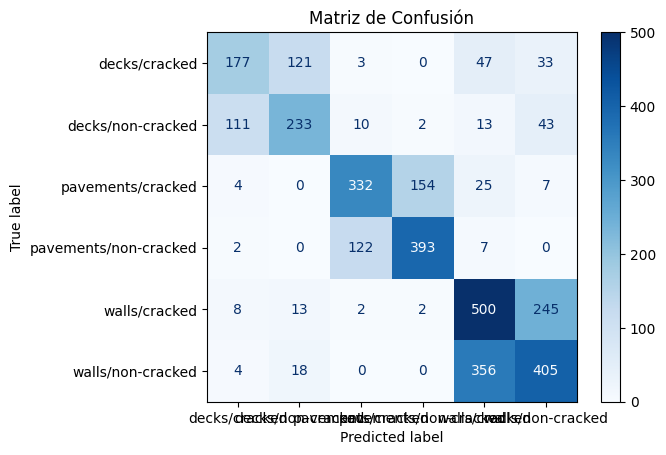

In [53]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "decks/cracked", "decks/non-cracked", "pavements/cracked",
    "pavements/non-cracked", "walls/cracked", "walls/non-cracked"
])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_resnet18.pth'))
